In [1]:
#!/bin/env python3

from argparse import ArgumentParser
from ast import Str

import numpy as np
import os
from os.path import join

from pathlib import Path

import pandas as pd
import pylab as plt
import random
import time
import warnings

from matplotlib.ticker import NullFormatter
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D


# wrapper for pylab, designed to do statistical plots using pandas dataframe 

from scipy.stats import beta, gaussian_kde


import sys
sys.path.append('/home/kblum/local/pism/sources/pism-emulator/')

from pismemulator.utils import param_keys_dict as keys_dict
from pismemulator.utils import kl_divergence
from pismemulator.kyle_utils import plot_random_groups, plot_posteriors, kl_divergences

import seaborn as sns



In [2]:
# Work in progess, this notebook is meant to plot several different randomly selected ensembles, subsets of the 200 that are avaiable

In [3]:
emulator_dirs = ['/data/work/antarctica_calibration/speedemulator/legacy_dirs/2021_11_pseudo_plastic_kb']
samples_files = {}

rc_samples_file = "/data/work/antarctica_calibration/speed_calibration_regularized_coulomb_128.csv"
pp_samples_file = "/data/work/antarctica_calibration/speed_calibration_pseudo_plastic_128.csv"

for emulator_dir in emulator_dirs:
    # This is janky, should find a better way to do this
    if 'rc_' in emulator_dir:
        samples_files[emulator_dir] = rc_samples_file
        print('rc')
    else:
        samples_files[emulator_dir] = pp_samples_file
        print('pp')

frac         = 0.1

print("Loading prior samples\n")
rc_samples = pd.read_csv(rc_samples_file).drop(columns=["id"])
pp_samples = pd.read_csv(pp_samples_file).drop(columns=["id"])

X_keys = rc_samples.keys()

l_post = []


pp
Loading prior samples



In [4]:
posterior_dfs = []
df_models     = []
titles        = []
for emulator_dir in emulator_dirs:
    X_list = []
    p = Path(f"{emulator_dir}/posterior_samples/")
    print("Loading posterior samples\n")
    for m, m_file in enumerate(sorted(p.glob("X_posterior_model_*.csv.gz"))):
        #print(f"  -- {m_file}")
        df = pd.read_csv(m_file).sample(frac=frac)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)
        model = m_file.name.split("_")[-1].split(".")[0]
        df["Model"] = int(model)
        X_list.append(df)

    print(f"Merging posteriors into dataframe")
    posterior_df = pd.concat(X_list)
    posterior_dfs.append(posterior_df)
    #X_posterior = posterior_df.drop(columns=["Model"]).values
    models = posterior_df['Model'].unique()
    df_models.append(models)
    titles.append(emulator_dir)



Loading posterior samples

Merging posteriors into dataframe


sia_e
ssa_e
ppq
tefo
phi_min
z_min
z_max
pseudo_plastic_uthreshold
None


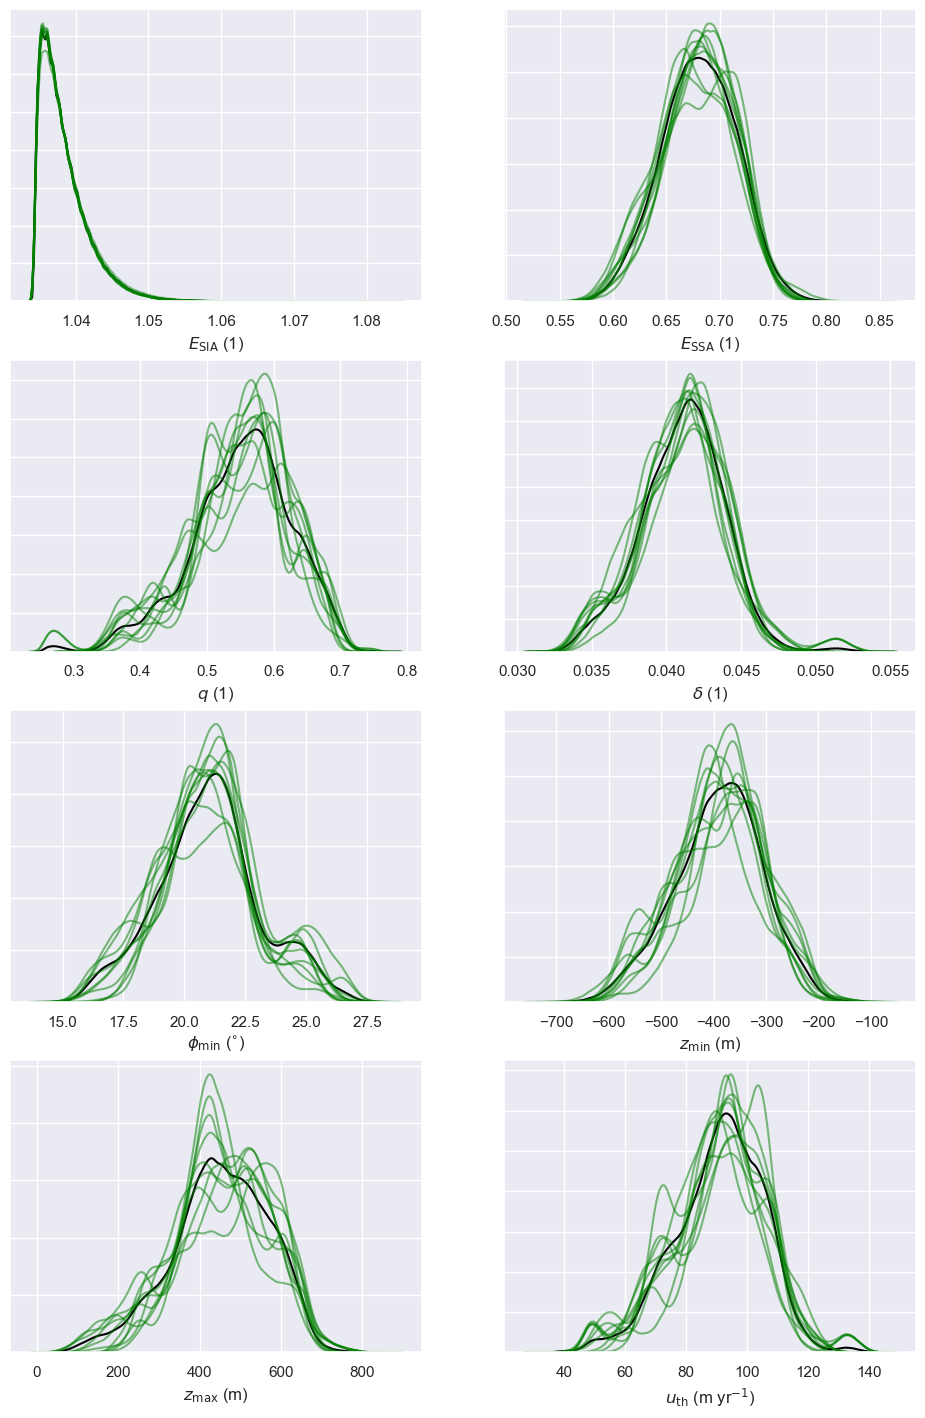

In [5]:
print(plot_random_groups(posterior_df, X_keys, models, per_group=50))

In [6]:
np.mean(posterior_df[X_keys])

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


sia_e                          1.038442
ssa_e                          0.680891
ppq                            0.551509
tefo                           0.041123
phi_min                       21.027652
z_min                       -390.374633
z_max                        450.898294
pseudo_plastic_uthreshold     90.995910
dtype: float64

In [7]:
np.seterr(invalid='ignore',divide='ignore')
lcurves = {}
xs = np.linspace(5,200,40)
for per_group in xs:
    print(per_group)
    lcurves[per_group] = kl_divergences(posterior_df, X_keys, models, per_group=int(per_group),num_groups=20)

5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0
105.0
110.0
115.0
120.0
125.0
130.0
135.0
140.0
145.0
150.0
155.0
160.0
165.0
170.0
175.0
180.0
185.0
190.0
195.0
200.0


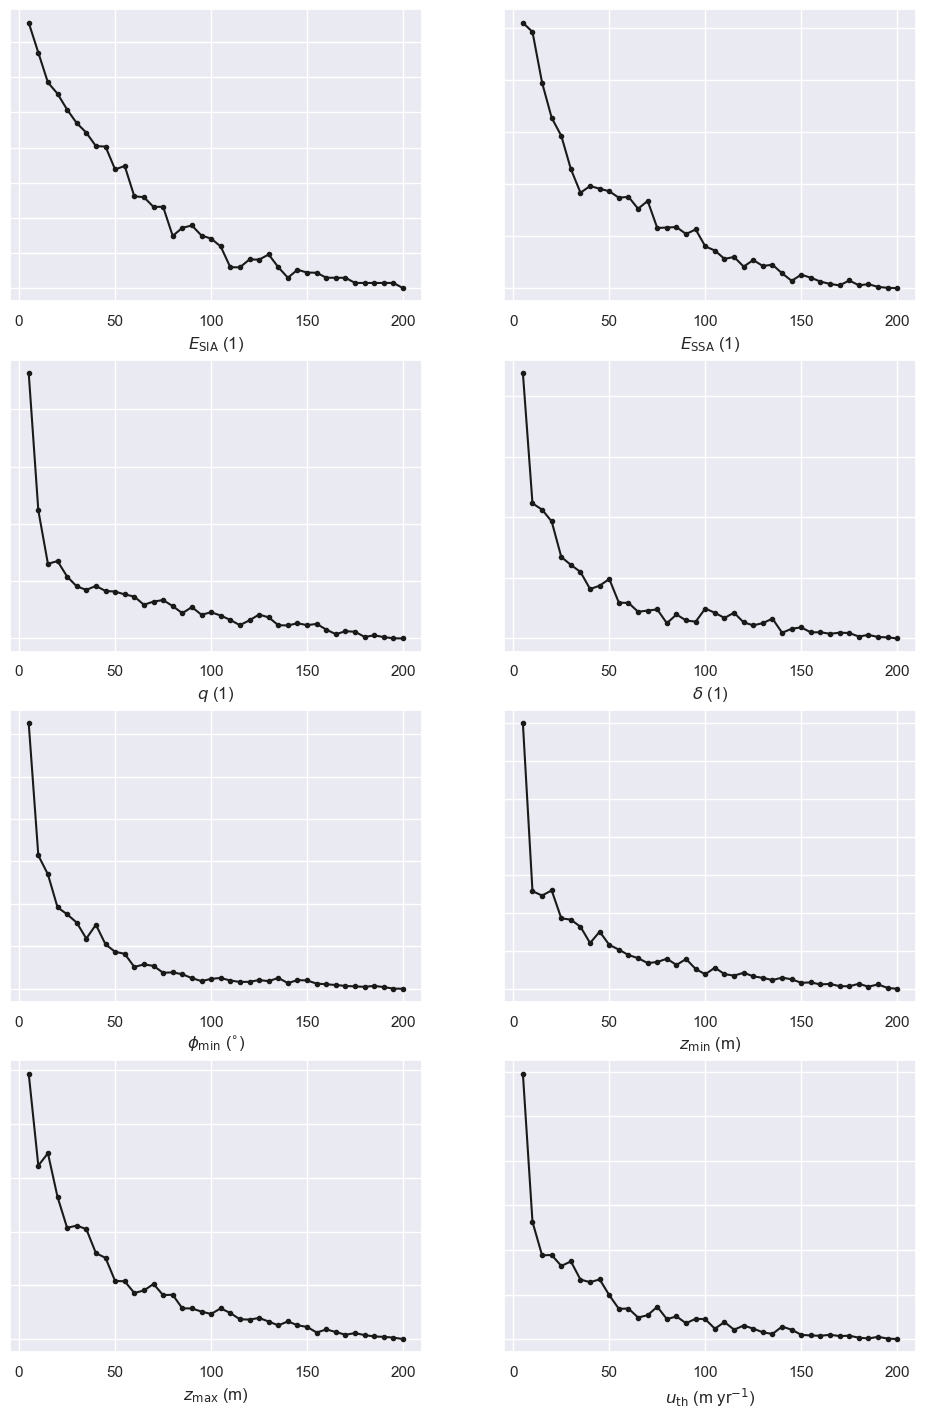

In [9]:
rows = int(np.ceil(len(X_keys)/2))
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
foo = 0

for i in range(rows):
    for j in range (cols):
        var = X_keys[foo]
        foo += 1
        ys = []
        for bar in xs:
            ys.append(lcurves[bar][var])
        
        axes[i,j].plot(xs,ys,'k.-')
        axes[i,j].set(xlabel=keys_dict[var],yticklabels=[],ylabel=None)


In [10]:
for pergroup in [15,50,100]:
    print(kl_divergences(posterior_df, X_keys, models, per_group=int(pergroup),num_groups=20)['ppq'])

6.518203444883417
4.095368668113059
2.288609189794328
